## Conexión al drive

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definición de la función beta

In [41]:
import math

def beta(E, m=938.272):
    γ = 1.0 + E/m
    return math.sqrt(1.0 - 1.0/γ**2)

Esta es la definición de la función beta para protones, con ella obtenemos beta teorica solo con darle una energía.
\
$\beta = \sqrt{1 - \frac{1}{\gamma^2}}$

donde el factor de Lorentz es:

$\gamma = 1 + \frac{E}{m}$

- \(E\): energía cinética de la partícula (en MeV).  
- \(m\): masa en reposo de la partícula.

## Definición de los Likelihood

In [42]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt


# Parámetros (TODO en mm)
D = 420  # mm
sigma1 = 3.74  # mm
sigma2 = 13.48  # mm
a1 = 0.76
a2 = 0.24
b = 0.78
n_refractive = 1.03  # Índice de refracción del aerogel


def P_hit(ri):
    signal = a1 * norm.pdf(ri, loc=0, scale=sigma1)
    return signal

def generate_ring_pattern(theta_c, track_dir, impact_point, num_points=100):
    radius = D * np.tan(theta_c)
    angles = np.linspace(0, 2 * np.pi, num_points)
    ring = np.array([
        impact_point + radius * np.array([np.cos(a), np.sin(a)])
        for a in angles
    ])
    return ring

def compute_distances(hits, ring):
    return [np.min(np.linalg.norm(ring - hit, axis=1)) for hit in hits]

def negative_log_likelihood(theta_c, hit_positions, track_direction, impact_point):
    predicted_ring = generate_ring_pattern(theta_c, track_direction, impact_point)
    ri_list = compute_distances(hit_positions, predicted_ring)
    likelihoods = [P_hit(ri) for ri in ri_list]
    return -np.sum(np.log(np.array(likelihoods) + 1e-12))

def estimate_beta(hit_positions, track_direction, impact_point):
    theta_max = np.arccos(1 / n_refractive)
    result = minimize_scalar(
        negative_log_likelihood,
        bounds=(0.1, theta_max),
        args=(hit_positions, track_direction, impact_point),
        method='bounded',
        options={'xatol': 1e-12}
    )
    best_theta_c = result.x
    beta = 1 / (n_refractive * np.cos(best_theta_c))
    return beta, best_theta_c

### 1. `P_hit(ri)`
- Calcula la probabilidad de que un **hit** a distancia `ri` provenga del anillo (signal)
---

### 2. `generate_ring_pattern(theta_c, track_dir, impact_point)`
- Genera un **anillo esperado** en el detector.  
- Usa:
  - `theta_c` → ángulo de Cherenkov  
  - `D * tan(theta_c)` → radio del anillo  
  - `impact_point` → centro del anillo  
- Devuelve un conjunto de puntos que forman el círculo.

---

### 3. `compute_distances(hits, ring)`
- Calcula la **distancia mínima** de cada hit al anillo esperado.  
- Devuelve una lista con las distancias `ri`.

---

### 4. `negative_log_likelihood(theta_c, hit_positions, track_direction, impact_point)`
- Genera un anillo con `theta_c`.  
- Calcula distancias `ri` entre hits y el anillo.  
- Evalúa probabilidades con `P_hit(ri)`.  
- Devuelve la **log-verosimilitud negativa**.  
  → Se minimiza para encontrar el mejor ajuste.

---

### 5. `estimate_beta(hit_positions, track_direction, impact_point)`
- Busca el `theta_c` que minimiza la log-verosimilitud negativa.  
- Con ese `theta_c`, estima la velocidad relativa de la partícula:  
$\beta = \frac{1}{n \cdot \cos(\theta_c)}$
- Devuelve `(beta, theta_c)`.

---


## Carga de datos, centrado y filtrado

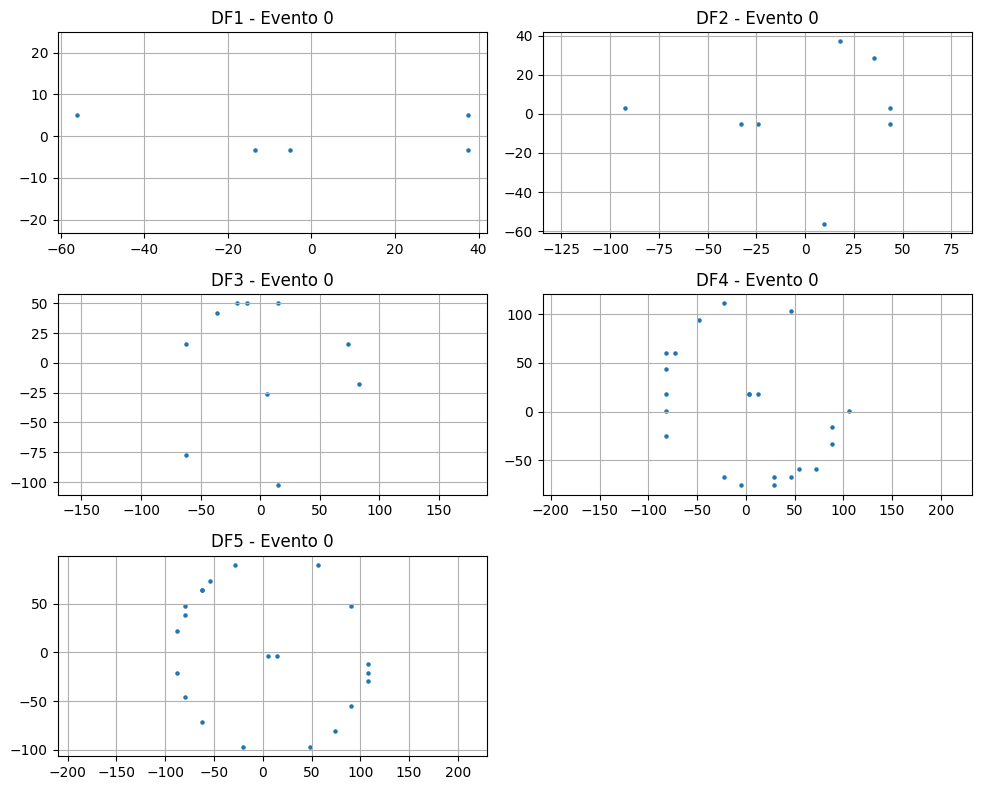

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Rutas
RUTA_CSV1 = "/content/drive/MyDrive/datos hits/P3_5GEV.csv"
RUTA_CSV2 = "/content/drive/MyDrive/datos hits/P4GEV.csv"
RUTA_CSV3 = "/content/drive/MyDrive/datos hits/P5GEV.csv"
RUTA_CSV4 = "/content/drive/MyDrive/datos hits/P7GEV.csv"
RUTA_CSV5 = "/content/drive/MyDrive/datos hits/P10GEV.csv"

# Cargar primeros hits de cada archivo
df1 = pd.read_csv(RUTA_CSV1).head(50000)
df2 = pd.read_csv(RUTA_CSV2).head(50000)
df3 = pd.read_csv(RUTA_CSV3).head(50000)
df4 = pd.read_csv(RUTA_CSV4).head(50000)
df5 = pd.read_csv(RUTA_CSV5).head(50000)


def cuantizar_hits(x, y, paso=8.5, x0=0.0, y0=0.0, modo="centro"):

    i = np.floor((x - x0) / paso).astype(int)
    j = np.floor((y - y0) / paso).astype(int)

    if modo == "centro":
        xq = x0 + (i + 0.5) * paso
        yq = y0 + (j + 0.5) * paso
    elif modo == "floor":
        xq = x0 + i * paso
        yq = y0 + j * paso
    else:
        raise ValueError("modo debe ser 'centro' o 'floor'")

    return xq, yq

dataframes = [df1, df2, df3, df4, df5]

for df in dataframes:
    df["x(mm)"], df["y(mm)"] = cuantizar_hits(
        df["x(mm)"].to_numpy(),
        df["y(mm)"].to_numpy(),
        paso=8.5, x0=0.0, y0=0.0, modo="centro"
    )

cols_to_center = ["x(mm)", "y(mm)"]

df_centered_list = []
for df in dataframes:
    # Asegurar numérico
    for col in cols_to_center:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df_centered = df.copy()

    # Guardar los centroides (medias por evento) -> devuelve dos columnas
    df_centered[["x0(mm)", "y0(mm)"]] = df_centered.groupby("eventID")[cols_to_center].transform("mean")

    # Centrar usando esas medias
    df_centered[cols_to_center] = df_centered[cols_to_center] - df_centered[["x0(mm)", "y0(mm)"]].to_numpy() #Centra los datos restando a cada punto el punto central real

    df_centered_list.append(df_centered)



# Graficar un evento por DataFrame
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 8))
axes = axes.flatten()
titles = ['DF1', 'DF2', 'DF3', 'DF4', 'DF5']

for i, df_centered in enumerate(df_centered_list):
    ax = axes[i]
    # Elegir el primer evento del DataFrame
    first_event = df_centered['eventID'].unique()[0]
    df_event = df_centered[df_centered['eventID'] == first_event]
    ax.scatter(df_event["x(mm)"], df_event["y(mm)"], s=5)
    ax.set_title(f"{titles[i]} - Evento {first_event}")
    ax.axis('equal')
    ax.grid(True)

# Si hay más subplots que DataFrames, ocultar el sobrante
for j in range(len(df_centered_list), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()




Carga los datos, los centra y gráfica uno de los ejemplos, elegí centrarlos sacando el punto central directamente de la simulación para evitar errores.

#Filtra los datasets quitando los datos dentro de un radio de 10 mm

In [44]:
import numpy as np

radio_minimo = 10  # mm

df_filtrados = []  # Aquí guardaremos los DataFrames filtrados

for df_centered in df_centered_list:
    # Calcular la distancia euclidiana desde el centro (0,0)
    distancia = np.sqrt(df_centered["x(mm)"]**2 + df_centered["y(mm)"]**2)

    # Filtrar solo los hits con distancia >= radio_minimo
    df_filtrado = df_centered[distancia >= radio_minimo].copy()

    df_filtrados.append(df_filtrado)


Este filtrado, elimina los puntos dentro de un radio de 10mm desde el origen para evitar los mayores errores posibles en la predicción de beta

## Distribuciones de probabilidad (Todas)

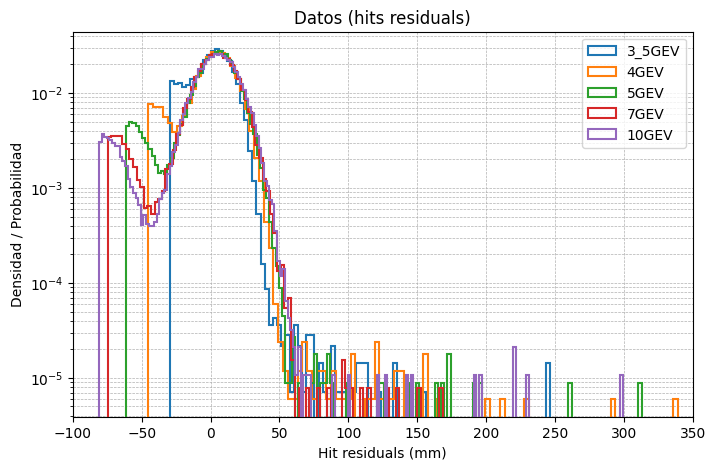

In [45]:
df = df_filtrados[0]
df1 = df_filtrados[1]
df2 = df_filtrados[2]
df3 = df_filtrados[3]
df4 = df_filtrados[4]

# Rango de residuos en mm
ri_vals = np.linspace(-60, 60, 500)  # mm

# Distribución teórica
P_vals = [P_hit(ri) for ri in ri_vals]

# Calcula hit residuals reales desde el dataframe
distancia = np.sqrt(df["x(mm)"]**2 + df["y(mm)"]**2)
residuals = distancia - distancia.mean()
distancia1 = np.sqrt(df1["x(mm)"]**2 + df1["y(mm)"]**2)
residuals1 = distancia1 - distancia1.mean()
distancia2 = np.sqrt(df2["x(mm)"]**2 + df2["y(mm)"]**2)
residuals2 = distancia2 - distancia2.mean()
distancia3 = np.sqrt(df3["x(mm)"]**2 + df3["y(mm)"]**2)
residuals3 = distancia3 - distancia3.mean()
distancia4 = np.sqrt(df4["x(mm)"]**2 + df4["y(mm)"]**2)
residuals4 = distancia4 - distancia4.mean()

# Grafica
plt.figure(figsize=(8,5))

# Histograma de datos reales
plt.hist(residuals, bins=200, density=True, histtype="step", linewidth=1.5, label="3_5GEV")
plt.hist(residuals1, bins=200, density=True, histtype="step", linewidth=1.5, label="4GEV")
plt.hist(residuals2, bins=200, density=True, histtype="step", linewidth=1.5, label="5GEV")
plt.hist(residuals3, bins=200, density=True, histtype="step", linewidth=1.5, label="7GEV")
plt.hist(residuals4, bins=200, density=True, histtype="step", linewidth=1.5, label="10GEV")

plt.xlim(-100, 350)  # Define el rango visual del eje x
plt.yscale('log')
plt.xlabel("Hit residuals (mm)")
plt.ylabel("Densidad / Probabilidad")
plt.title("Datos (hits residuals)")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.show()


Gráfica las distribuciones de probabilidad de los datos por energía

In [46]:
print(df1)

       eventID  pmtID    x(mm)    y(mm)  z(mm)  energy(MeV)    x0(mm)  \
0            0   9924  18.0625  37.1875  210.0       4000.0 -379.3125   
1            0  10376  35.0625  28.6875  210.0       4000.0 -379.3125   
2            0   9457   9.5625 -56.3125  210.0       4000.0 -379.3125   
3            0  10829  43.5625  -5.3125  210.0       4000.0 -379.3125   
4            0  10830  43.5625   3.1875  210.0       4000.0 -379.3125   
...        ...    ...      ...      ...    ...          ...       ...   
49993     5222  51207 -51.8500  20.4000  210.0       4000.0  532.1000   
49994     5222  52976  -9.3500  45.9000  210.0       4000.0  532.1000   
49995     5222  54979  67.1500 -13.6000  210.0       4000.0  532.1000   
49996     5222  52446 -17.8500 -73.1000  210.0       4000.0  532.1000   
49997     5222  53127  -0.8500 -13.6000  210.0       4000.0  532.1000   

         y0(mm)  
0      315.5625  
1      315.5625  
2      315.5625  
3      315.5625  
4      315.5625  
...         ...

## Ajuste hits gaussiana hits 1

In [47]:
df = df_filtrados[0]

# Rango de residuos en mm
ri_vals = np.linspace(-50, 50, 500)  # mm

# Distribución teórica
P_vals = [P_hit(ri) for ri in ri_vals]

# Calcula hit residuals reales desde el dataframe
distancia = np.sqrt(df["x(mm)"]**2 + df["y(mm)"]**2)
residuals = distancia - distancia.mean()

En esta parte se obtienen los residuales de los hits para ver las distancias entre el punto medio y los demás

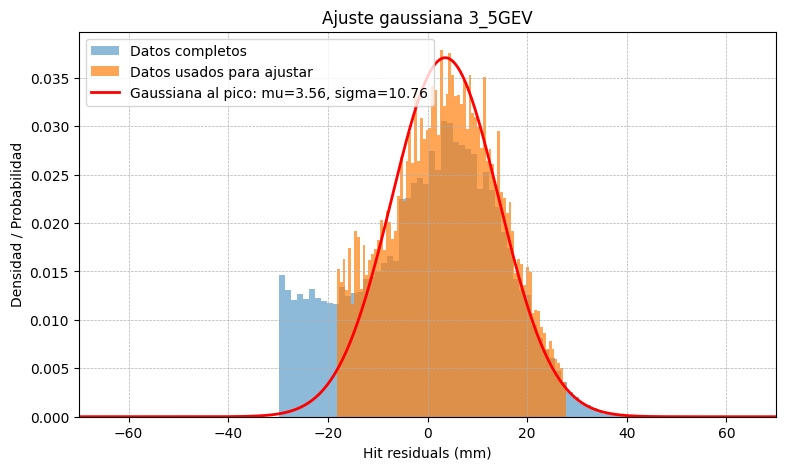

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks
import seaborn as sns

resid_cut = residuals[np.abs(residuals) < 3000]  #Un filtro a los datos con el que estaba experimentando pero que no tiene relevancia en esta versión
data = resid_cut.copy()

# Usa histograma para encontrar el pico
counts, bin_edges = np.histogram(data, bins=200, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
peak_idx = np.argmax(counts)
mode_est = bin_centers[peak_idx]

# Selecciona ventana alrededor del pico
window = 23.0
mask = (data >= mode_est - window) & (data <= mode_est + window)
central = data[mask]

# Ajuste normal a datos centrales
mu1, sigma1 = norm.fit(central)

# Grafica
x = np.linspace(-150, 150, 800)
plt.figure(figsize=(9,5))
plt.hist(data, bins=500, density=True, alpha=0.5, label='Datos completos')
plt.hist(central, bins=80, density=True, alpha=0.7, label='Datos usados para ajustar')
plt.plot(x, norm.pdf(x, mu1, sigma1), 'r-', lw=2, label=f'Gaussiana al pico: mu={mu1:.2f}, sigma={sigma1:.2f}')
plt.xlim(-70, 70)
plt.xlabel("Hit residuals (mm)")
plt.ylabel("Densidad / Probabilidad")
plt.title("Ajuste gaussiana 3_5GEV")
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()


Este bloque de código busca estimar los parámetros de una distribución normal (media y desviación estándar) a partir de un conjunto de datos, centrándose en la región del **pico principal**.

1. **Encontrar el pico con un histograma:**  
   - Se construye un histograma de los datos (`data`) con `200` bins y con la opción `density=True` (para obtener una distribución de probabilidad normalizada).  
   - Se calculan los centros de cada bin (`bin_centers`).  
   - Se localiza el índice del bin con la mayor frecuencia (`peak_idx`), es decir, el máximo del histograma.  
   - Con ese índice se obtiene una estimación de la **moda** (`mode_est`), que es la posición del pico.  

2. **Seleccionar una ventana alrededor del pico:**  
   - Se define un valor `window = 23.0` que establece el rango alrededor de la moda.  
   - Se seleccionan únicamente los datos que caen dentro de este intervalo (`central`).  
   - Esto permite enfocar el ajuste en la parte central de la distribución, evitando valores muy alejados (colas).  

3. **Ajustar una normal a los datos centrales:**  
   - Se aplica `norm.fit(central)`, que estima los parámetros de la distribución normal que mejor se ajusta a esos datos centrales.  
   - El resultado son `mu1` (media estimada) y `sigma1` (desviación estándar estimada).  


4. **Gráfica**

En resumen:  
Este código primero localiza el pico de la distribución de los datos con un histograma, selecciona los valores cercanos a ese pico mediante una ventana definida, y finalmente ajusta una **distribución normal** en esa región para obtener sus parámetros característicos.


In [49]:
from scipy.stats import norm

# Seleccionaa ventana alrededor del pico
mask = (resid_cut > -window) & (resid_cut < window)
central = resid_cut[mask]

#Histograma dentro de esa misma ventana
counts, bin_edges = np.histogram(central, bins=500, range=(-window, window))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# Modelo esperado en cada bin
pdf_vals = norm.pdf(bin_centers, mu1, sigma1)
expected = pdf_vals * len(central) * bin_width  # escalar a cuentas

# Obtiene chi-cuadrado
chi21 = np.sum((counts - expected) ** 2 / (expected + 1e-9))  # evitar div/0

# Parámetros: mu y sigma (2 parámetros libres)
n_bins = len(counts)
n_params = 2
ndof1 = n_bins - n_params - 1

chi21_red = chi21 / ndof1

print("\n=== Estadísticos del ajuste al pico ===")
print(f"Chi-cuadrado = {chi21:.2f}")
print(f"Grados de libertad = {ndof1}")
print(f"Chi-cuadrado reducido = {chi21_red:.2f}")



=== Estadísticos del ajuste al pico ===
Chi-cuadrado = 21547.53
Grados de libertad = 497
Chi-cuadrado reducido = 43.36


Este bloque de código realiza una evaluación de qué tan bien una distribución **gaussiana** se ajusta a los datos alrededor de un pico en un histograma.  

1. **Selección de ventana:**  
   Se toman los datos contenidos en un rango definido por `window` alrededor del pico (`resid_cut`).  

2. **Construcción del histograma:**  
   Se cuenta cuántos datos caen en cada intervalo (bin), obteniendo `counts` (observado), los bordes de los bins (`bin_edges`) y sus centros (`bin_centers`).  

3. **Modelo gaussiano esperado:**  
   Se calcula la densidad de probabilidad de una gaussiana con media `mu1` y desviación estándar `sigma1`, y luego se escala para que tenga el mismo número total de cuentas que el histograma (`expected`).  

4. **Cálculo de chi-cuadrado:**  
   Se evalúa la discrepancia entre los valores observados (`counts`) y los esperados (`expected`) mediante la fórmula del estadístico chi-cuadrado:  

   $\chi^2 = \sum \frac{(O - E)^2}{E}$

   donde \(O\) son las cuentas observadas y \(E\) las esperadas.  
   Para evitar divisiones por cero, se añade un pequeño término \(1\text{e-9}\).  

5. **Grados de libertad:**  
   Se calculan como el número de bins menos el número de parámetros libres (aquí, `mu` y `sigma`) menos uno.  

6. **Chi-cuadrado reducido:**  
   Se obtiene al dividir el chi-cuadrado entre los grados de libertad. Un valor cercano a **1** indica un ajuste razonablemente bueno; valores mucho mayores a 1 sugieren que el modelo no describe bien los datos, y valores mucho menores a 1 suelen indicar sobreajuste o que las incertidumbres están sobreestimadas.  

Estos codigos se repiten para los demás datos

## Ajuste hits gaussiana hits 2

In [50]:
df = df_filtrados[1]

# Rango de residuos en mm
ri_vals = np.linspace(-50, 50, 500)  # mm

# Distribución teórica
P_vals = [P_hit(ri) for ri in ri_vals]

# Calcula hit residuals reales desde el dataframe
distancia = np.sqrt(df["x(mm)"]**2 + df["y(mm)"]**2)
residuals = distancia - distancia.mean()

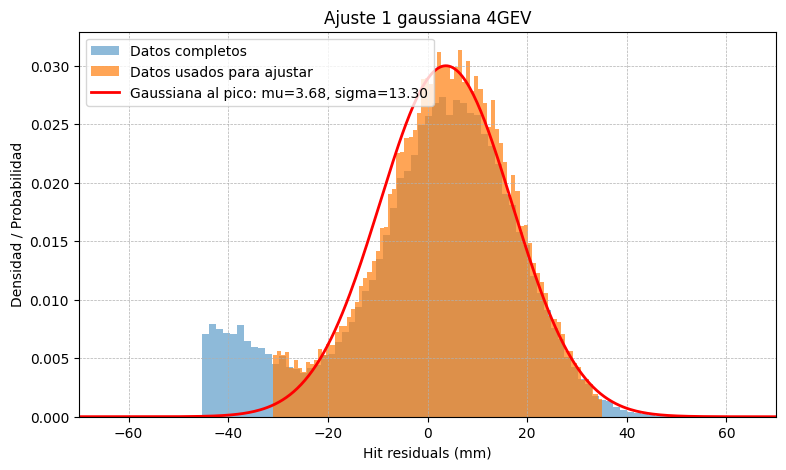

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks
import seaborn as sns

resid_cut = residuals[np.abs(residuals) < 3000]  # ya lo tenías
data = resid_cut.copy()

# 1) Estimación del modo: usar histograma o KDE para encontrar el pico
counts, bin_edges = np.histogram(data, bins=200, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
peak_idx = np.argmax(counts)
mode_est = bin_centers[peak_idx]

# 2) Seleccionar ventana alrededor del pico (ej: ± window mm)
window = 33.0  # ajusta esto: 20-60 mm según tu caso
mask = (data >= mode_est - window) & (data <= mode_est + window)
central = data[mask]

# 3) Ajuste normal a datos centrales
mu2, sigma2 = norm.fit(central)

# 4) Graficar
x = np.linspace(-150, 150, 800)
plt.figure(figsize=(9,5))
plt.hist(data, bins=500, density=True, alpha=0.5, label='Datos completos')
plt.hist(central, bins=80, density=True, alpha=0.7, label='Datos usados para ajustar')
plt.plot(x, norm.pdf(x, mu2, sigma2), 'r-', lw=2, label=f'Gaussiana al pico: mu={mu2:.2f}, sigma={sigma2:.2f}')
plt.xlim(-70, 70)
plt.xlabel("Hit residuals (mm)")
plt.ylabel("Densidad / Probabilidad")
plt.title("Ajuste 1 gaussiana 4GEV")
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

In [52]:
from scipy.stats import norm

# --- Paso 1: seleccionar ventana alrededor del pico ---
mask = (resid_cut > -window) & (resid_cut < window)
central = resid_cut[mask]

# --- Paso 2: ajuste gaussiano simple ---
mu, sigma = mu2, sigma2

# --- Paso 3: histograma dentro de esa misma ventana ---
counts, bin_edges = np.histogram(central, bins=500, range=(-window, window))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# --- Paso 4: modelo esperado en cada bin ---
pdf_vals = norm.pdf(bin_centers, mu, sigma)
expected = pdf_vals * len(central) * bin_width  # escalar a cuentas

# --- Paso 5: chi-cuadrado ---
chi22 = np.sum((counts - expected) ** 2 / (expected + 1e-9))  # evitar div/0

# Parámetros: mu y sigma (2 parámetros libres)
n_bins = len(counts)
n_params = 2
ndof2 = n_bins - n_params - 1

chi22_red = chi22 / ndof2

print("\n=== Estadísticos del ajuste al pico ===")
print(f"Chi-cuadrado = {chi22:.2f}")
print(f"Grados de libertad = {ndof2}")
print(f"Chi-cuadrado reducido = {chi22_red:.2f}")


=== Estadísticos del ajuste al pico ===
Chi-cuadrado = 6498.20
Grados de libertad = 497
Chi-cuadrado reducido = 13.07


## Ajuste hits gaussiana hits 3
---



In [53]:
df = df_filtrados[2]

# Rango de residuos en mm
ri_vals = np.linspace(-50, 50, 500)  # mm

# Distribución teórica
P_vals = [P_hit(ri) for ri in ri_vals]

# Calcula hit residuals reales desde el dataframe
distancia = np.sqrt(df["x(mm)"]**2 + df["y(mm)"]**2)
residuals = distancia - distancia.mean()

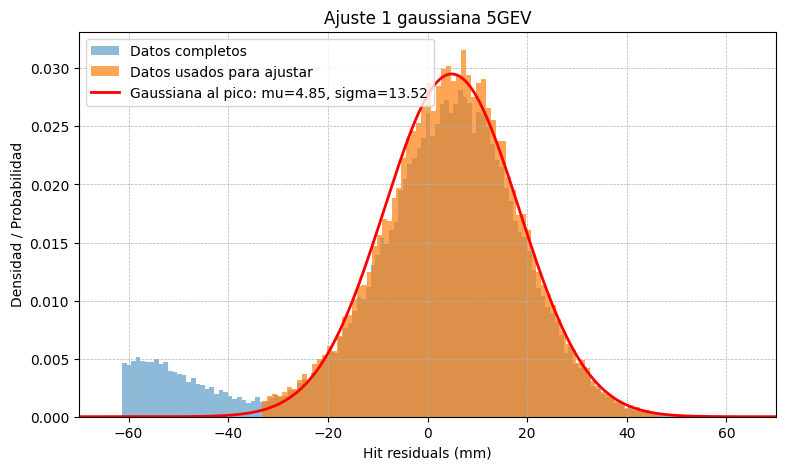

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks
import seaborn as sns

resid_cut = residuals[np.abs(residuals) < 3000]  # ya lo tenías
data = resid_cut.copy()

# 1) Estimación del modo: usar histograma o KDE para encontrar el pico
counts, bin_edges = np.histogram(data, bins=200, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
peak_idx = np.argmax(counts)
mode_est = bin_centers[peak_idx]

# 2) Seleccionar ventana alrededor del pico (ej: ± window mm)
window = 40.0  # ajusta esto: 20-60 mm según tu caso
mask = (data >= mode_est - window) & (data <= mode_est + window)
central = data[mask]

# 3) Ajuste normal a datos centrales
mu3, sigma3 = norm.fit(central)

# 4) Graficar
x = np.linspace(-150, 150, 800)
plt.figure(figsize=(9,5))
plt.hist(data, bins=500, density=True, alpha=0.5, label='Datos completos')
plt.hist(central, bins=80, density=True, alpha=0.7, label='Datos usados para ajustar')
plt.plot(x, norm.pdf(x, mu3, sigma3), 'r-', lw=2, label=f'Gaussiana al pico: mu={mu3:.2f}, sigma={sigma3:.2f}')
#plt.yscale('log')
plt.xlim(-70, 70)
plt.xlabel("Hit residuals (mm)")
plt.ylabel("Densidad / Probabilidad")
plt.title("Ajuste 1 gaussiana 5GEV")
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()


In [55]:
from scipy.stats import norm

# --- Paso 1: seleccionar ventana alrededor del pico ---
mask = (resid_cut > -window) & (resid_cut < window)
central = resid_cut[mask]

# --- Paso 3: histograma dentro de esa misma ventana ---
counts, bin_edges = np.histogram(central, bins=500, range=(-window, window))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# --- Paso 4: modelo esperado en cada bin ---
pdf_vals = norm.pdf(bin_centers, mu3, sigma3)
expected = pdf_vals * len(central) * bin_width  # escalar a cuentas

# --- Paso 5: chi-cuadrado ---
chi23 = np.sum((counts - expected) ** 2 / (expected + 1e-9))  # evitar div/0

# Parámetros: mu y sigma (2 parámetros libres)
n_bins = len(counts)
n_params = 2
ndof3 = n_bins - n_params - 1

chi23_red = chi23 / ndof3

print("\n=== Estadísticos del ajuste al pico ===")
print(f"Chi-cuadrado = {chi23:.2f}")
print(f"Grados de libertad = {ndof3}")
print(f"Chi-cuadrado reducido = {chi23_red:.2f}")


=== Estadísticos del ajuste al pico ===
Chi-cuadrado = 4231.62
Grados de libertad = 497
Chi-cuadrado reducido = 8.51


## Ajuste hits gaussiana hits 4

In [56]:
df = df_filtrados[3]

# Rango de residuos en mm
ri_vals = np.linspace(-50, 50, 500)  # mm

# Distribución teórica
P_vals = [P_hit(ri) for ri in ri_vals]

# Calcula hit residuals reales desde el dataframe
distancia = np.sqrt(df["x(mm)"]**2 + df["y(mm)"]**2)
residuals = distancia - distancia.mean()

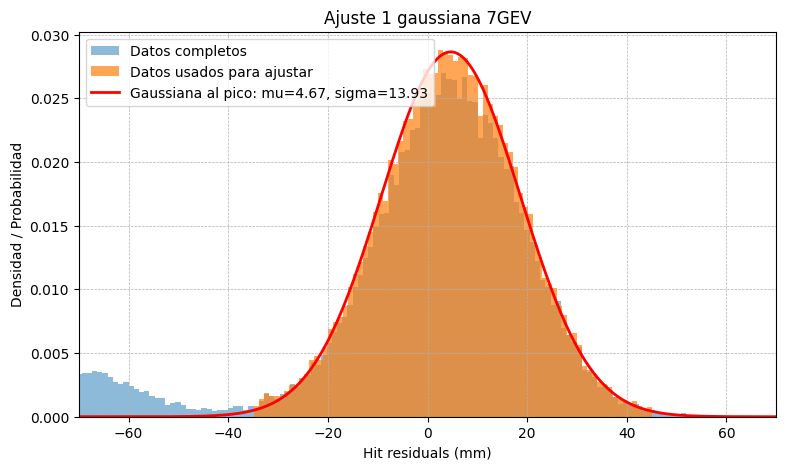

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks
import seaborn as sns

resid_cut = residuals[np.abs(residuals) < 3000]  # ya lo tenías
data = resid_cut.copy()

# 1) Estimación del modo: usar histograma o KDE para encontrar el pico
counts, bin_edges = np.histogram(data, bins=200, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
peak_idx = np.argmax(counts)
mode_est = bin_centers[peak_idx]

# 2) Seleccionar ventana alrededor del pico (ej: ± window mm)
window = 40.0  # ajusta esto: 20-60 mm según tu caso
mask = (data >= mode_est - window) & (data <= mode_est + window)
central = data[mask]

# 3) Ajuste normal a datos centrales
mu4, sigma4 = norm.fit(central)

# 4) Graficar
x = np.linspace(-150, 150, 800)
plt.figure(figsize=(9,5))
plt.hist(data, bins=500, density=True, alpha=0.5, label='Datos completos')
plt.hist(central, bins=80, density=True, alpha=0.7, label='Datos usados para ajustar')
plt.plot(x, norm.pdf(x, mu4, sigma4), 'r-', lw=2, label=f'Gaussiana al pico: mu={mu4:.2f}, sigma={sigma4:.2f}')
#plt.yscale('log')
plt.xlim(-70, 70)
plt.xlabel("Hit residuals (mm)")
plt.ylabel("Densidad / Probabilidad")
plt.title("Ajuste 1 gaussiana 7GEV")
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

In [58]:
from scipy.stats import norm

# --- Paso 1: seleccionar ventana alrededor del pico ---
mask = (resid_cut > -window) & (resid_cut < window)
central = resid_cut[mask]

# --- Paso 3: histograma dentro de esa misma ventana ---
counts, bin_edges = np.histogram(central, bins=500, range=(-window, window))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# --- Paso 4: modelo esperado en cada bin ---
pdf_vals = norm.pdf(bin_centers, mu4, sigma4)
expected = pdf_vals * len(central) * bin_width  # escalar a cuentas

# --- Paso 5: chi-cuadrado ---
chi24 = np.sum((counts - expected) ** 2 / (expected + 1e-9))  # evitar div/0

# Parámetros: mu y sigma (2 parámetros libres)
n_bins = len(counts)
n_params = 2
ndof4 = n_bins - n_params - 1

chi24_red = chi24 / ndof4

print("\n=== Estadísticos del ajuste al pico ===")
print(f"Chi-cuadrado = {chi24:.2f}")
print(f"Grados de libertad = {ndof4}")
print(f"Chi-cuadrado reducido = {chi24_red:.2f}")


=== Estadísticos del ajuste al pico ===
Chi-cuadrado = 1068.47
Grados de libertad = 497
Chi-cuadrado reducido = 2.15


## Ajuste hits gaussiana hits 5

In [59]:
df = df_filtrados[4]

# Rango de residuos en mm
ri_vals = np.linspace(-50, 50, 500)  # mm

# Distribución teórica
P_vals = [P_hit(ri) for ri in ri_vals]

# Calcula hit residuals reales desde el dataframe
distancia = np.sqrt(df["x(mm)"]**2 + df["y(mm)"]**2)
residuals = distancia - distancia.mean()

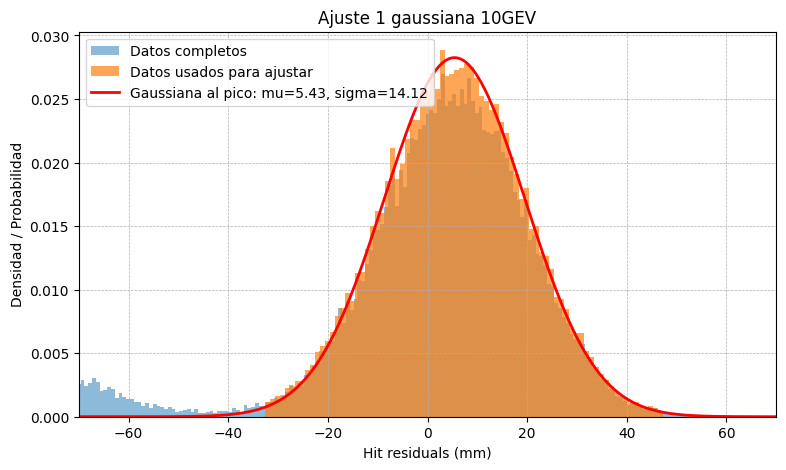

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks
import seaborn as sns

resid_cut = residuals[np.abs(residuals) < 3000]  # ya lo tenías
data = resid_cut.copy()

# 1) Estimación del modo: usar histograma o KDE para encontrar el pico
counts, bin_edges = np.histogram(data, bins=200, density=True)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
peak_idx = np.argmax(counts)
mode_est = bin_centers[peak_idx]

# 2) Seleccionar ventana alrededor del pico (ej: ± window mm)
window = 40.0  # ajusta esto: 20-60 mm según tu caso
mask = (data >= mode_est - window) & (data <= mode_est + window)
central = data[mask]

# 3) Ajuste normal a datos centrales
mu5, sigma5 = norm.fit(central)

# 4) Graficar
x = np.linspace(-150, 150, 800)
plt.figure(figsize=(9,5))
plt.hist(data, bins=500, density=True, alpha=0.5, label='Datos completos')
plt.hist(central, bins=80, density=True, alpha=0.7, label='Datos usados para ajustar')
plt.plot(x, norm.pdf(x, mu5, sigma5), 'r-', lw=2, label=f'Gaussiana al pico: mu={mu5:.2f}, sigma={sigma5:.2f}')
#plt.yscale('log')
plt.xlim(-70, 70)
plt.xlabel("Hit residuals (mm)")
plt.ylabel("Densidad / Probabilidad")
plt.title("Ajuste 1 gaussiana 10GEV")
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

In [61]:
from scipy.stats import norm

# --- Paso 1: seleccionar ventana alrededor del pico ---
mask = (resid_cut > -window) & (resid_cut < window)
central = resid_cut[mask]

# --- Paso 3: histograma dentro de esa misma ventana ---
counts, bin_edges = np.histogram(central, bins=500, range=(-window, window))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_width = bin_edges[1] - bin_edges[0]

# --- Paso 4: modelo esperado en cada bin ---
pdf_vals = norm.pdf(bin_centers, mu5, sigma5)
expected = pdf_vals * len(central) * bin_width  # escalar a cuentas

# --- Paso 5: chi-cuadrado ---
chi25 = np.sum((counts - expected) ** 2 / (expected + 1e-9))  # evitar div/0

# Parámetros: mu y sigma (2 parámetros libres)
n_bins = len(counts)
n_params = 2
ndof5 = n_bins - n_params - 1

chi25_red = chi25 / ndof5

print("\n=== Estadísticos del ajuste al pico ===")
print(f"Chi-cuadrado = {chi25:.2f}")
print(f"Grados de libertad = {ndof5}")
print(f"Chi-cuadrado reducido = {chi25_red:.2f}")


=== Estadísticos del ajuste al pico ===
Chi-cuadrado = 857.31
Grados de libertad = 497
Chi-cuadrado reducido = 1.72


## LISTA DE CHI2 y GRADOS DE LIBERTAD

In [62]:
chi2 = [chi21, chi22, chi23, chi24, chi25]
print(chi2)
chi2_red = [chi21_red, chi22_red, chi23_red, chi24_red, chi25_red]
print(chi2_red)

[np.float64(21547.533246627187), np.float64(6498.202457346689), np.float64(4231.624965733588), np.float64(1068.474311140681), np.float64(857.3118187318227)]
[np.float64(43.35519767933035), np.float64(13.07485403892694), np.float64(8.514335947150077), np.float64(2.1498477085325574), np.float64(1.7249734783336472)]


In [63]:
ndof = [ndof1, ndof2, ndof3, ndof4, ndof5]
print(ndof)

[497, 497, 497, 497, 497]


Acá muestro los chi cuadrados y los grados de libertad

## Graficas parametros vs energía

In [64]:
sigmas1 = [sigma1, sigma2, sigma3, sigma4, sigma5]
medias1 = [mu1, mu2, mu3, mu4, mu5] #Guarda las sigmas y las medias en una lista para facilidad de uso

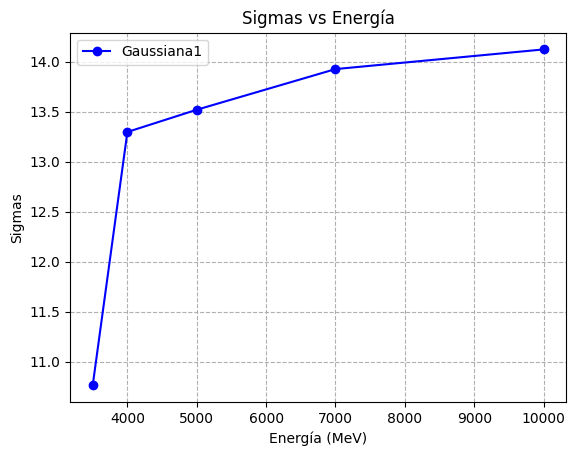

In [65]:
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit

E = [3500, 4000, 5000, 7000, 10000]

spline1 = CubicSpline(E, sigmas1)

plt.plot(E, sigmas1, marker='o', color='blue', label='Gaussiana1')

plt.title('Sigmas vs Energía')
plt.xlabel('Energía (MeV)')
plt.ylabel('Sigmas')

plt.legend()
plt.grid(True, which="both", ls="--")  # "both" = grid en mayor y menor escala log
plt.show()

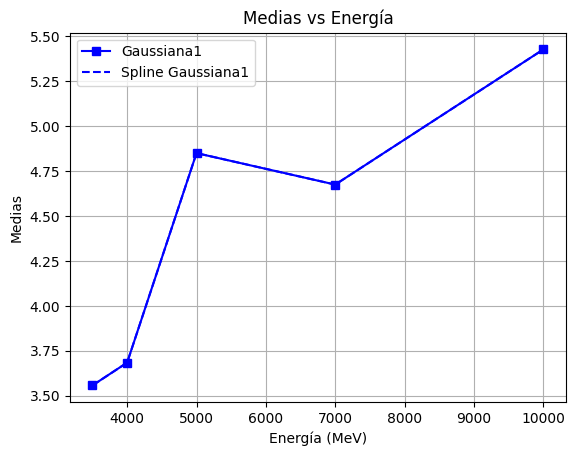

In [66]:
spline3 = CubicSpline(E, medias1)
plt.plot(E, medias1, marker='s', color='blue', label='Gaussiana1')
plt.plot(E, spline3(E), color='blue', linestyle='--', label='Spline Gaussiana1')
plt.title('Medias vs Energía')
plt.xlabel('Energía (MeV)')
plt.ylabel('Medias')
plt.legend()
plt.grid(True)
plt.show()

## En escala logaritmica para la energía

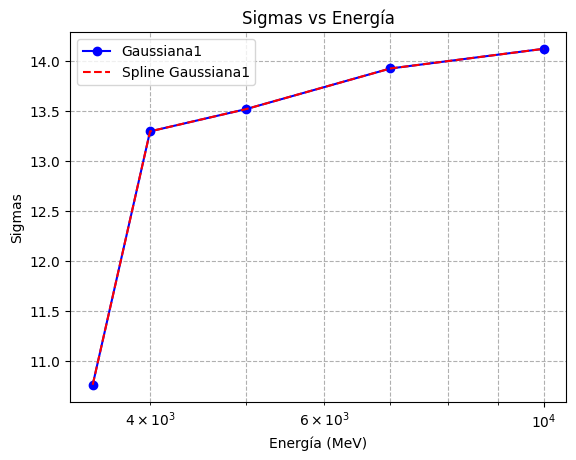

In [67]:

plt.plot(E, sigmas1, marker='o', color='blue', label='Gaussiana1')
plt.plot(E, spline1(E), color='red', linestyle='--', label='Spline Gaussiana1')

plt.title('Sigmas vs Energía')
plt.xlabel('Energía (MeV)')
plt.ylabel('Sigmas')

plt.xscale('log')

plt.legend()
plt.grid(True, which="both", ls="--")  # "both" = grid en mayor y menor escala log
plt.show()

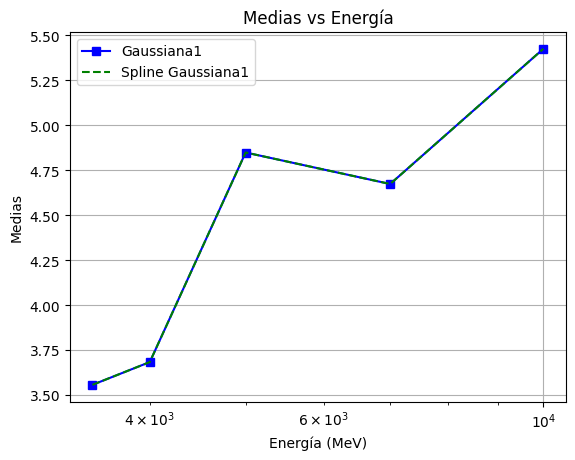

In [68]:
plt.plot(E, medias1, marker='s', color='blue', label='Gaussiana1')
plt.plot(E, spline3(E), color='green', linestyle='--', label='Spline Gaussiana1')
plt.title('Medias vs Energía')
plt.xlabel('Energía (MeV)')
plt.ylabel('Medias')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

En esta parte solo se graficaron las medias y sigmas vs las energías tanto con los ejes lineales como en escala logaritmica.

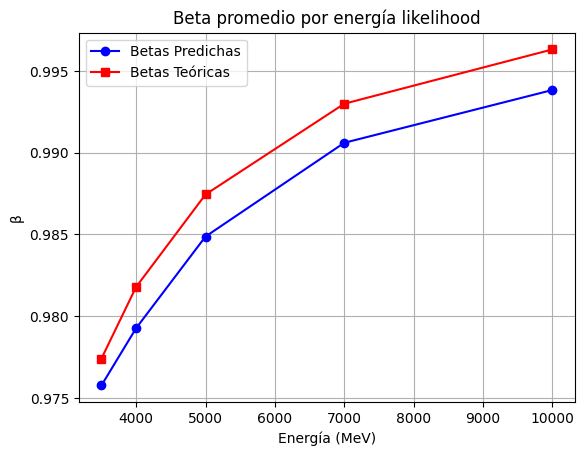

In [69]:
from scipy.stats import gaussian_kde

# Dirección de la partícula y punto de impacto (centrado en 0)
track_dir = np.array([0, 0, 1])
impact_point = np.array([0, 0])


# Parámetros (TODO en mm)
D = 420  # mm
sigma1 = sigma1 # mm
a1 = 1
n_refractive = 1.03  # Índice de refracción del aerogel


def P_hit(ri):
    signal = a1 * norm.pdf(ri, mu1, scale=sigma1)
    return signal

# Energías para cada archivo
E = [3500, 4000, 5000, 7000, 10000]
betas_teo = [beta(e) for e in E]

# Energía del archivo (ajusta según el caso)
E1 = E[0]
beta_teo = beta(E1)
beta_promedio1 = np.nan

betas_evento1 = []
betas_evento2 = []
betas_evento3 = []
betas_evento4 = []
betas_evento5 = []

# Iterar sobre cada evento
for eventID in df_filtrados[0]["eventID"].unique():
    df_event = df_filtrados[0][df_filtrados[0]["eventID"] == eventID]
    hits = df_event[["x(mm)", "y(mm)"]].values

    # Filtra eventos con suficientes hits
    if len(hits) >= 5:
        try:
            beta_est, theta_est = estimate_beta(hits, track_dir, impact_point)
            betas_evento1.append(beta_est)
        except:
            continue  # Por si estimate_beta falla

# Calcular promedio de este df
if betas_evento1:
    beta_promedio1 = np.mean(betas_evento1)

sigma1 = sigma2 # mm
a1 = 1

def P_hit(ri):
    signal = a1 * norm.pdf(ri, mu2, scale=sigma1)
    return signal

E2 = E[1]
beta_teo = beta(E2)
beta_promedio2 = np.nan

betas_evento = []

# Iterar sobre cada evento
for eventID in df_filtrados[1]["eventID"].unique():
    df_event = df_filtrados[1][df_filtrados[1]["eventID"] == eventID]
    hits = df_event[["x(mm)", "y(mm)"]].values

    # Filtra eventos con suficientes hits
    if len(hits) >= 5:
        try:
            beta_est, theta_est = estimate_beta(hits, track_dir, impact_point)
            betas_evento2.append(beta_est)
        except:
            continue  # Por si estimate_beta falla

# Calcular promedio de este df
if betas_evento2:
    beta_promedio2 = np.mean(betas_evento2)

sigma1 = sigma3 # mm

def P_hit(ri):
    signal = a1 * norm.pdf(ri, mu3, scale=sigma1)
    return signal

E3 = E[2]
beta_teo = beta(E3)
beta_promedio3 = np.nan

betas_evento = []

# Iterar sobre cada evento
for eventID in df_filtrados[2]["eventID"].unique():
    df_event = df_filtrados[2][df_filtrados[2]["eventID"] == eventID]
    hits = df_event[["x(mm)", "y(mm)"]].values

    # Filtra eventos con suficientes hits
    if len(hits) >= 5:
        try:
            beta_est, theta_est = estimate_beta(hits, track_dir, impact_point)
            betas_evento3.append(beta_est)
        except:
            continue  # Por si estimate_beta falla

# Calcular promedio de este df
if betas_evento3:
    beta_promedio3 = np.mean(betas_evento3)

sigma1 = sigma4 # mm

def P_hit(ri):
    signal = a1 * norm.pdf(ri, mu4, scale=sigma1)
    return signal

E4 = E[3]
beta_teo = beta(E4)
beta_promedio4 = np.nan

betas_evento = []

# Iterar sobre cada evento
for eventID in df_filtrados[3]["eventID"].unique():
    df_event = df_filtrados[3][df_filtrados[3]["eventID"] == eventID]
    hits = df_event[["x(mm)", "y(mm)"]].values

    # Filtra eventos con suficientes hits
    if len(hits) >= 5:
        try:
            beta_est, theta_est = estimate_beta(hits, track_dir, impact_point)
            betas_evento4.append(beta_est)
        except:
            continue  # Por si estimate_beta falla

# Calcular promedio de este df
if betas_evento4:
    beta_promedio4 = np.mean(betas_evento4)

sigma1 = sigma5 # mm

def P_hit(ri):
    signal = a1 * norm.pdf(ri, mu5, scale=sigma1)
    return signal

E5 = E[4]
beta_teo = beta(E5)
beta_promedio5 = np.nan

betas_evento = []

# Iterar sobre cada evento
for eventID in df_filtrados[4]["eventID"].unique():
    df_event = df_filtrados[4][df_filtrados[4]["eventID"] == eventID]
    hits = df_event[["x(mm)", "y(mm)"]].values

    # Filtra eventos con suficientes hits
    if len(hits) >= 5:
        try:
            beta_est, theta_est = estimate_beta(hits, track_dir, impact_point)
            betas_evento5.append(beta_est)
        except:
            continue  # Por si estimate_beta falla

# Calcular promedio de este df
if betas_evento5:
    beta_promedio5 = np.mean(betas_evento5)

beta_promedios = [beta_promedio1, beta_promedio2, beta_promedio3, beta_promedio4, beta_promedio5]

betas_eventos = [betas_evento1, betas_evento2, betas_evento3, betas_evento4, betas_evento5]

bet = []

for i, betas in enumerate(betas_eventos, start=1):
    sigma = np.std(betas)  # desviación estándar

    # Estimación de densidad
    kde = gaussian_kde(betas)
    beta_range = np.linspace(min(betas), max(betas), 1000)
    kde_values = kde(beta_range)
    beta_mode = beta_range[np.argmax(kde_values)]  # valor más probable
    bet.append(beta_mode)

# Graficar
plt.plot(E, bet, marker='o', color='blue', label='Betas Predichas')
plt.plot(E, betas_teo, marker='s', color='red', label='Betas Teóricas')
plt.title('Beta promedio por energía likelihood')
plt.xlabel('Energía (MeV)')
plt.ylabel('β')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
print(bet)
print(beta_teo)

[np.float64(0.975756837043685), np.float64(0.979260374245802), np.float64(0.9848639242905803), np.float64(0.9906006032458664), np.float64(0.9938300999387085)]
0.9963142049869926


El código procesa datos experimentales de cinco energías distintas, estima la distribución de β en cada caso, extrae el **valor más probable** de β mediante KDE y finalmente compara esos resultados con los valores **teóricos** calculados a partir de la energía.  

1. **Definición de parámetros y función de probabilidad:**
   - Se definen el vector de dirección de la partícula (`track_dir`) y el punto de impacto (`impact_point`).  
   - Se establecen parámetros experimentales: distancia al detector `D`, desviaciones `sigmaX` y el índice de refracción del aerogel.  
   - La función `P_hit(ri)` modela la probabilidad de impacto como una gaussiana centrada en distintos valores `muX` y con ancho `sigmaX`.

2. **Energías a analizar:**
   - Se lista un conjunto de energías (`E`) y se calculan los valores teóricos de β (`betas_teo`) con una función auxiliar `beta(e)`.  

3. **Procesamiento de datos por energía:**
   - Para cada archivo/energía (cinco en total), se recorre cada evento (`eventID`) en el dataframe correspondiente (`df_filtrados[i]`).  
   - Se obtienen las posiciones de impacto (`hits`) en el plano del detector.  
   - Si el evento tiene suficientes impactos (≥5), se estima β y el ángulo Cherenkov (`theta`) mediante la función `estimate_beta`.  
   - Los valores estimados de β se guardan en listas separadas (`betas_evento1`, ..., `betas_evento5`).  
   - Se calcula un promedio de β por energía (`beta_promedioX`).  

4. **Cálculo de valores más probables:**
   - En lugar de usar únicamente el promedio, se obtiene la distribución de β en cada energía con un **KDE (Kernel Density Estimation)** usando `gaussian_kde`.  
   - De esta densidad se extrae el **modo** (valor más probable de β) como el máximo de la curva suavizada.  
   - Estos valores se almacenan en la lista `bet`.

5. **Visualización:**
   - Se grafican los valores experimentales (modo de β por energía) contra los valores teóricos (`betas_teo`).  
   - El gráfico permite ver la concordancia (o desviación) entre los resultados medidos y el modelo esperado.  


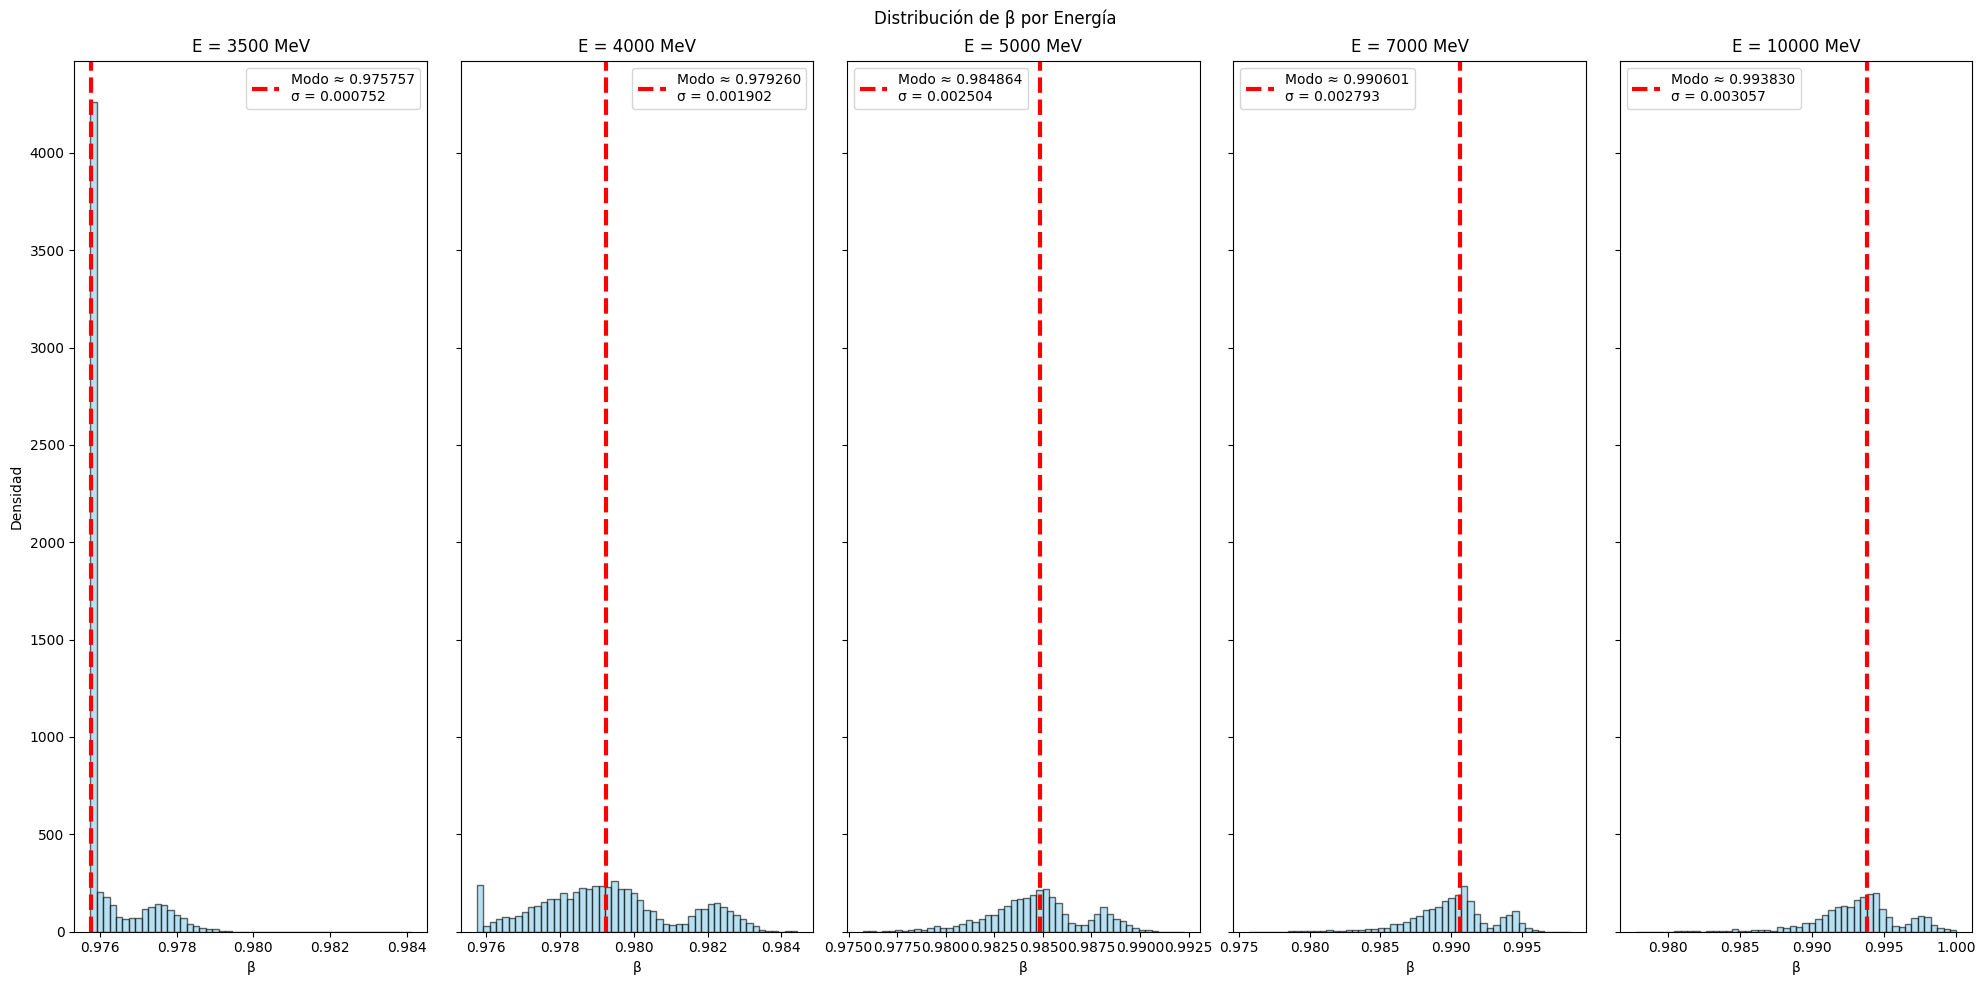

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

betas_eventos = [betas_evento1, betas_evento2, betas_evento3, betas_evento4, betas_evento5]

fig, axs = plt.subplots(1, 5, figsize=(20, 10), sharey=True)

for i, betas in enumerate(betas_eventos, start=1):
    sigma = np.std(betas)  # desviación estándar

    # Estimación de densidad
    kde = gaussian_kde(betas)
    beta_range = np.linspace(min(betas), max(betas), 1000)
    kde_values = kde(beta_range)
    beta_mode = beta_range[np.argmax(kde_values)]  # valor más probable

    axs[i-1].hist(betas, bins=50, color="skyblue", edgecolor="black", alpha=0.6, density=True)
    axs[i-1].axvline(beta_mode, linestyle='--', linewidth=3, color="red",
                     label=f'Modo ≈ {beta_mode:.6f}\nσ = {sigma:.6f}')
    axs[i-1].set_title(f"E = {E[i-1]} MeV")
    axs[i-1].set_xlabel("β")
    axs[i-1].legend()
    if i == 1:
        axs[i-1].set_ylabel("Densidad")

plt.suptitle("Distribución de β por Energía")
plt.tight_layout()
plt.show()



En esta parte gráfica los diferentes valores de beta predichos y se marca el más probable

## Grafica de las distribuciones de betas predichas de acuerdo a su energía

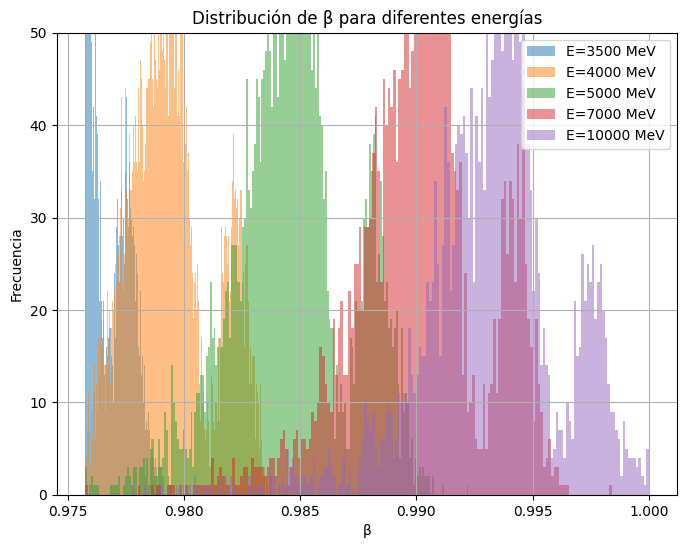

In [72]:
plt.figure(figsize=(8,6))

plt.hist(betas_evento1, bins=200, alpha=0.5, label=f"E={E[0]} MeV")
plt.hist(betas_evento2, bins=200, alpha=0.5, label=f"E={E[1]} MeV")
plt.hist(betas_evento3, bins=200, alpha=0.5, label=f"E={E[2]} MeV")
plt.hist(betas_evento4, bins=200, alpha=0.5, label=f"E={E[3]} MeV")
plt.hist(betas_evento5, bins=200, alpha=0.5, label=f"E={E[4]} MeV")

plt.xlabel("β")
plt.ylabel("Frecuencia")
plt.ylim(0,50)
plt.title("Distribución de β para diferentes energías")
plt.legend()
plt.grid(True)
plt.show()


## Gráfica del ajuste lineal a las betas predichas contra las beta teóricas

Pendiente de las betas predichas (m): 0.9176756464305577
Pendiente de las betas teóricas (m): 1.000000000000011
Diferencia de pendientes: 0.08232435356945345


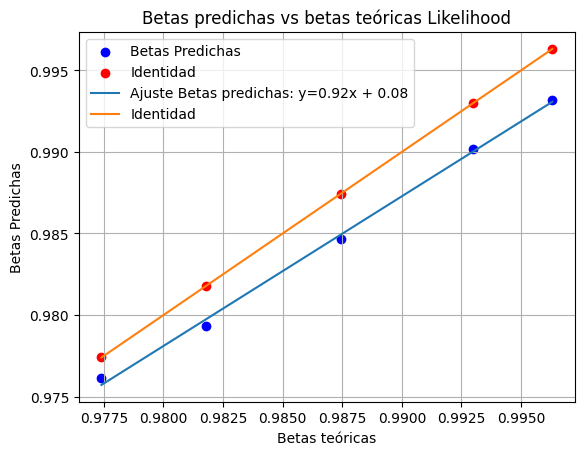

In [73]:
betas_teo = np.array(betas_teo, dtype=float)
beta_promedios = np.array(beta_promedios, dtype=float)

m1, b1 = np.polyfit(betas_teo, beta_promedios, 1)
m2, b2 = np.polyfit(betas_teo, betas_teo, 1)
print(f"Pendiente de las betas predichas (m): {m1}")
print(f"Pendiente de las betas teóricas (m): {m2}")
print(f'Diferencia de pendientes: {np.abs(m1-m2)}')

plt.scatter(betas_teo, beta_promedios, marker='o', color='blue', label='Betas Predichas')
plt.scatter(betas_teo, betas_teo, marker='o', color='red', label='Identidad')
plt.plot(betas_teo, m1*betas_teo + b1, label=f'Ajuste Betas predichas: y={m1:.2f}x + {b1:.2f}')
plt.plot(betas_teo, m2*betas_teo + b2, label=f'Identidad')
plt.title('Betas predichas vs betas teóricas Likelihood')
plt.xlabel('Betas teóricas')
plt.ylabel('Betas Predichas')
plt.legend()
plt.grid(True)
plt.show()

# R cuadrado

In [74]:
import numpy as np

# Convertir las listas a arrays de numpy para cálculos numéricos
betas_reales = np.array(betas_teo, dtype=float)
betas_predichas = np.array(bet, dtype=float)

# Calcular la media de los valores reales (teóricos)
media_reales = np.mean(betas_reales)

# Calcular la suma total de los cuadrados (SS_tot)
ss_tot = np.sum((betas_reales - media_reales)**2)

# Calcular la suma de los cuadrados de los residuos (SS_res)
ss_res = np.sum((betas_reales - betas_predichas)**2)

# Calcular el R-cuadrado usando la fórmula
r2 = 1 - (ss_res / ss_tot)

print(f"El valor de R-cuadrado (R²) es: {r2:.6f}")

El valor de R-cuadrado (R²) es: 0.886082


## Estimación de una sola beta

In [75]:
#10GEV
beta_est, theta_est = estimate_beta(hits, track_dir, impact_point)
print(f"Beta estimada: {beta_est:.6f}")

Beta estimada: 0.991513


## Gráfica de un solo evento con su predicción

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Tus datos
data = np.array([
    [  82.96,  -44.54],
    [  91.46,   48.96],
    [-104.04,    6.46],
    [  82.96,  -36.04],
    [  65.96,   74.46],
    [  40.46,  -87.04],
    [ -44.54,  -87.04],
    [   6.46,  -95.54],
    [-104.04,  -19.04],
    [  74.46,  -53.04],
    [  91.46,  -19.04],
    [ -44.54,  -87.04],
    [ -70.04,  -70.04],
    [  74.46,   65.96],
    [-104.04,  -10.54],
    [  57.46,  -70.04],
    [ -95.54,   40.46],
    [ -53.04,  -87.04],
    [ -78.54,   74.46],
    [ -78.54,   74.46],
    [ -19.04,  108.46],
    [  57.46,   82.96],
    [  65.96,   82.96],
    [   6.46,   99.96]
])

# Separar columnas en x e y
x = data[:,0]
y = data[:,1]

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def graficar_anillo_cherenkov(puntos, beta, theta, n=1.03, D=420, centro=(0,0), color="red"):

    # Radio
    R = D * np.tan(theta)

    # Graficar
    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_aspect("equal")

    # Hits
    puntos = np.array(puntos)
    ax.scatter(puntos[:,0], puntos[:,1], color="blue", s=40, label="Hits")

    # Círculo global
    circle = plt.Circle(centro, R, fill=False, color=color, linewidth=2, label="Anillo Cherenkov")
    ax.add_patch(circle)

    ax.set_xlabel("X [mm]")
    ax.set_ylabel("Y [mm]")
    ax.set_title(f"Anillo de Cherenkov (β={beta:.4f}, n={n}, D={D})")
    ax.legend()
    plt.grid(True)
    plt.show()



Esta es la función para graficar el anillo desde la theta predicha por likelihood, usa la expresión teórica:  $R = D \cdot \tan(\theta)$, y con plt.circle y el radio, gráfica el anillo

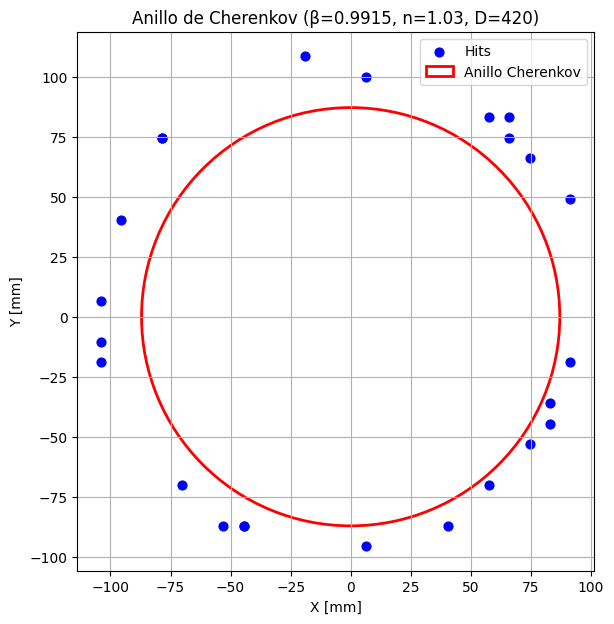

In [78]:
graficar_anillo_cherenkov(data, beta_est, theta_est)